

<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Introduction to Machine Learning - 25732  <br>
<font color=2565AE size=5>
Department of Electrical Enginnering <br>
Fall 2024<br>
<font color=3C99D size=5>
Dr. Mohammad Hossein Yassaee <br>
<font color=696880 size=4>
Zahra Maleki


____




### Information:

1.   Full Name: Seyyed Amirmahdi Sadrzadeh
2.   Student Number: 401102015

---

*I. You are just allowded to change those parts that start with "TO DO". Please do not change other parts.*

*II. It is highly recommended to read each codeline carefully and try to understand what it exactly does.*

*III. Do not copy codes completely from internet sources such as Chat-GPT or etc. If you are using any sources, please put its link in the beging of the block.*

If you have any question you can contact related TAs:
 - Homeworks coordinator: @danialayati
 - This Notebook: @Rosebaekfany

 Best of luck and have fun!

---

## Introduction

## Fitting a function with *gradient descent*
We'll be using *numpy* and *pytorch* for array calculations in this notebook.
A neural network is just a mathematical function. In the most standard kind of neural network, the function:

1. Multiplies each input by a number of values. These values are known as *parameters*
1. Adds them up for each group of values
1. Replaces the negative numbers with zeros

This represents one "layer". Then these three steps are repeated, using the outputs of the previous layer as the inputs to the next layer. Initially, the parameters in this function are selected randomly. Therefore a newly created neural network doesn't do anything useful at all -- it's just random!

To get the function to "learn" to do something useful, we have to change the parameters to make them "better" in some way. We do this using *gradient descent*. Let's see how this works...

In [6]:
from ipywidgets import interact
from fastai.basics import *
from functools import partial
import torch
import numpy

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

To learn how gradient descent works, we're going to start by fitting a quadratic, since that's a function most of us are probably more familiar with than a neural network. Here's the quadratic we're going to try to fit:

Write a Python function that represents the quadratic equation \( f(x) = 3x^2 + 2x + 1 \), and then create a plot of this function labeled with its mathematical representation.

In [11]:
def my_quad(x):
  return 3 * x**2 + 2 * x + 1

This quadratic is of the form $ax^2+bx+c$, with parameters $a=3$, $b=2$, $c=1$. To make it easier to try out different quadratics for fitting a model to the data we'll create, Now create a function that calculates the value of a point on any quadratic:

In [3]:
def any_quad(a, b, c, x):
  return a * x**2 + b * x + c

If we fix some particular values of a, b, and c, then we'll have made a quadratic. To fix values passed to a function in python, we use the `partial` function, like so:

In [7]:
def mk_quad(a,b,c):
  return partial(any_quad, a, b, c)

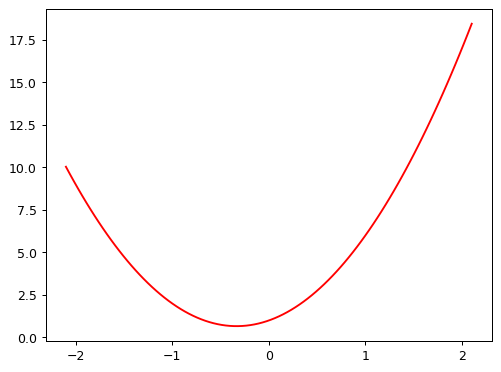

In [5]:
f2 = mk_quad(3,2,1)
plot_function(f2)

Now let's simulate making some noisy measurements of our quadratic `f`. We'll then use gradient descent to see if we can recreate the original function from the data.

write down a couple of functions to add some random noise to data:

In [8]:
def noise(x, scale): return scale * torch.randn_like(x)
def add_noise(x, mult, add): return x * (1 + noise(x, mult)) + noise(x, add)

Let's use the now to create our noisy measurements based on the quadratic above:

In [19]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(my_quad(x), 0.15, 1.5)

show the first few values of each of `x` and `y`:

In [20]:
print("First few values of x:")
print(x[:5])

print("\nFirst few values of y:")
print(y[:5])

First few values of x:
tensor([[-2.0000],
        [-1.7895],
        [-1.5789],
        [-1.3684],
        [-1.1579]])

First few values of y:
tensor([[12.0112],
        [ 8.6819],
        [ 4.4412],
        [ 4.6922],
        [ 3.3947]])


As you can see, they're *tensors*. A tensor is just like an `array` in numpy. Furthermore, PyTorch, which most researchers use for deep learning, is modeled closely on numpy.) A tensor can be a single number (a *scalar* or *rank-0 tensor*), a list of numbers (a *vector* or *rank-1 tensor*), a table of numbers (a *matrix* or *rank-2 tensor*), a table of tables of numbers (a *rank-3 tensor*), and so forth.

We're not going to learn much about our data by just looking at the raw numbers, so let's draw a picture:

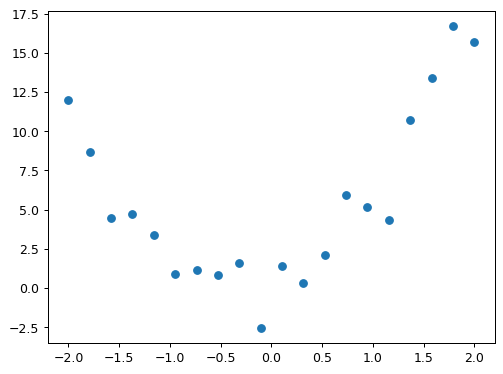

In [21]:
plt.scatter(x,y);

How do we find values of a, b, and c which fit this data? One approach is to try a few values and see what fits. Here's a function which overlays a quadratic on top of our data, along with some sliders to change a, b, and c, and see how it looks:

In [22]:
@interact(a=(-5.0, 5.0, 0.1), b=(-5.0, 5.0, 0.1), c=(-5.0, 5.0, 0.1))
def plot_quad(a, b, c):
  f = any_quad(a, b, c, x)
  plt.scatter(x, y, color='blue', alpha=0.5, label="Noisy Data")
  plt.plot(x, f, 'r', label=f"Fitted Quadratic: {a}x^2 + {b}x + {c}")
  plt.title("Quadratic Fitting with Adjustable Parameters")
  plt.xlabel("x")
  plt.ylabel("f(x)")
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)
  plt.grid(True)
  plt.legend()
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='a', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

Try moving slider `a` a bit to the left. Does that look better or worse? How about if you move it a bit to the right? Find out which direction seems to improve the fit of the quadratic to the data, and move the slider a bit in that direction. Next, do the same for slider `b`: first figure out which direction improves the fit, then move it a bit in that direction. Then do the same for `c`.

OK, now go back to slider `a` and repeat the process. Do it again for `b` and `c` as well.

Did you notice that by going back and doing the sliders a second time that you were able to improve things a bit further? That's an important insight -- it's only after changing `b` and `c`, for instance, that you realise that `a` actually needs some adjustment based on those new values.

One thing that's making this tricky is that we don't really have a great sense of whether our fit is really better or worse. It would be easier if we had a numeric measure of that. On easy metric we could use is *mean absolute error* -- which is the distance from each data point to the curve:

Answer:

We can see that by increaning the value of a, b and c at first, we get a better fit. But as a gets closer to 3.1, the increase in its value worsens the fit. and also when we settle for the a value, we change b and c again to get to the final fit.

In [23]:
def mae(preds, acts): return torch.mean(torch.abs(preds-acts))

We'll update our interactive function to print this at the top for us.

Use this to repeat the approach we took before to try to find the best fit, but this time just use the value of the metric to decide which direction to move each slider, and how far to move it.

This time around, try doing it in the opposite order: `c`, then `b`, then `a`.

You'll probably find that you have to go through the set of sliders a couple of times to get the best fit.

In [ ]:
@interact(...)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f, y)
    plot_function(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

In a modern neural network we'll often have tens of millions of parameters to fit, or more, and thousands or millions of data points to fit them to. We're not going to be able to do that by moving sliders around! We'll need to automate this process.

Thankfully, that turns out to be pretty straightforward. We can use calculus to figure out, for each parameter, whether we should increase or decrease it.

Uh oh, calculus! If you haven't touched calculus since school, you might be getting ready to run away at this point. But don't worry, we don't actually need much calculus at all. Just derivatives, which measure the rate of change of a function. We don't even need to calculate them ourselves, because the computer will do it for us!

## Automating gradient descent
The basic idea is this: if we know the *gradient* of our `mae()` function *with respect to* our parameters, `a`, `b`, and `c`, then that means we know how adjusting (for instance) `a` will change the value of `mae()`. If, say, `a` has a *negative* gradient, then we know that increasing `a` will decrease `mae()`. Then we know that's what we need to do, since we trying to make `mae()` as low as possible.

So, we find the gradient of `mae()` for each of our parameters, and then adjust our parameters a bit in the *opposite* direction to the sign of the gradient.

To do this, first we need a function that takes all the parameters `a`, `b`, and `c` as a single vector input, and returns the value `mae()` based on those parameters:

In [ ]:
def quad_mae(params):
    #code here

In [ ]:
quad_mae([1.1, 1.1, 1.1])

Yup, that's the same as the starting `mae()` we had in our plot before.

We're first going to do exactly the same thing as we did manually -- pick some arbritrary starting point for our parameters. We'll put them all into a single tensor.

To tell PyTorch that we want it to calculate gradients for these parameters.

We can now calculate `mae()`. Generally, when doing gradient descent, the thing we're trying to minimise is called the *loss*:

In [ ]:
#code here
print(loss)

Get PyTorch to now calculate the gradients.

The gradients will be stored for us in an attribute called `grad`.


In [ ]:
#code here

According to these gradients, all our parameters are a little low. So let's increase them a bit. If we subtract the gradient, multiplied by a small number, that should improve them a bit.

In [ ]:
#code here
print(f'loss={loss:.2f}')

Yes, our loss has gone down!

The "small number" we multiply is called the *learning rate*, and is the most important *hyper-parameter* to set when training a neural network.

We can use a loop to do a few more iterations of this:

In [ ]:
#code here

As you can see, our loss keeps going down!

If you keep running this loop for long enough however, you'll see that the loss eventually starts increasing for a while. That's because once the parameters get close to the correct answer, our parameter updates will jump right over the correct answer! To avoid this, we need to decrease our learning rate as we train. This is done using a *learning rate schedule*, and can be automated in most deep learning frameworks, such as fastai and PyTorch.

## How a neural network approximates any given function

But neural nets are much more convenient and powerful than this example showed, because we can learn much more than just a quadratic with them. How does *that* work?


The trick is that a neural network is a very expressive function. A neural network can approximate any computable function, given enough parameters. A "computable function" can cover just about anything you can imagine: understand and translate human speech; paint a picture; diagnose a disease from medical imaging; write an essay; etc...

The way a neural network approximates a function actually turns out to be very simple. The key trick is to combine two extremely basic steps:

1. Matrix multiplication, which is just multiplying things together and then adding them up
1. The function $max(x,0)$, which simply replaces all negative numbers with zero.

The combination of a linear function and this *max()* is called a *rectified linear function*.

In [ ]:
def rectified_linear(m,b,x):
    #code here

In [ ]:
plot_function(partial(rectified_linear, 1,1))

we can instead use `relu(x)`, which does exactly the same thing.

In [ ]:
def rectified_linear2(m,b,x): #code here
plot_function(partial(rectified_linear2, 1,1))

To understand how this function works, try using this interactive version to play around with the parameters `m` and `b`:

In [ ]:
#code here

As you see, `m` changes the slope, and `b` changes where the "hook" appears. This function doesn't do much on its own, but look what happens when we add two of them together:

In [ ]:
def double_relu(m1,b1,m2,b2,x):
    return ...

@interact(...)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

If you play around with that for a while, you notice something quite profound: with enough of these rectified linear functions added together, you could approximate any function with a single input, to whatever accuracy you like! Any time the function doesn't quite match, you can just add a few more additions to the mix to make it a bit closer. As an experiment, perhaps you'd like to try creating your own `plot_triple_relu` interactive function, and maybe even include the scatter plot of our data from before, to see how close you can get?

This exact same approach can be expanded to functions of 2, 3, or more parameters.

In [ ]:
#Bonus
def plot_triple_relu():
    ...

Now put them all together and try to learn the best function that fits your generated data(x,y) using only nueral networks as best as you can.

you will see in the future how best is actully defined!

In [ ]:
#code here